In [1]:
import optuna
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
import numpy as np
import scipy.cluster.hierarchy as sch

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from typing import Callable
from pathlib import Path

C:\Users\20318156\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.
* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

# General functions

In [2]:
def unique_report(sample: pd.DataFrame | pd.Series, features: list[str]) -> None:
    """Print feature, count of unique values & unique values"""
    for feature in features:
        print(
            f"Feature: {feature}\n \
            Unique values count: {sample[feature].unique().shape}\n \
            Unique values: {sample[feature].unique()}\n"
        )

def plot_hists_box(sample: pd.DataFrame | pd.Series, features: list[str]) -> None:
    """Plot hist & plot for every feature in list"""
    for feature in features:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
        sns.histplot(data=sample, x=feature, ax=ax[0])
        sns.boxplot(data=sample, x=feature, ax=ax[1])

def plot_feature_importance(model, predictors, model_name):
    """Plot feature importance"""
    feature_imp=pd.DataFrame(sorted(zip(model.feature_importances_, predictors.columns)), columns=['Value','Feature'])
    plt.figure(figsize=(10, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
    plt.title(f"{model_name} Most Important Features")
    plt.tight_layout()
    plt.show()

# Special functions

In [3]:
OPTUNA_EARLY_STOPING = 20

class EarlyStoppingExceeded(optuna.exceptions.OptunaError):
    """Represents exception class that raised to stop tuning"""
    early_stop = OPTUNA_EARLY_STOPING
    early_stop_count = 0
    best_score = None

def early_stopping_opt(study, trial):
    """Callback to stop tuning if score remain the same"""
    if EarlyStoppingExceeded.best_score == None:
        EarlyStoppingExceeded.best_score = study.best_value
    elif study.best_value < EarlyStoppingExceeded.best_score:
        EarlyStoppingExceeded.best_score = study.best_value
        EarlyStoppingExceeded.early_stop_count = 0
    else:
        if EarlyStoppingExceeded.early_stop_count > EarlyStoppingExceeded.early_stop:
            EarlyStoppingExceeded.early_stop_count = 0
            best_score = None
            raise EarlyStoppingExceeded()
        else:
            EarlyStoppingExceeded.early_stop_count=EarlyStoppingExceeded.early_stop_count+1
    return

class Optimizer:
    """Represents class to tune hyper parameters using optuna"""
    def __init__(self, train_x, train_y, model_class, scoring="f1", cv=5):
        self.train_x = train_x
        self.train_y = train_y
        self.model_class = model_class
        self.scoring = scoring
        self.cv = cv

    def _objective(self, trial):
        """Objective function to tune hyperparameters"""
        search_space = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "learning_rate": trial.suggest_float("learning_rate", 1e-8, 0.125),
            "max_depth": trial.suggest_int("max_depth", 2, 9),
            "subsample": trial.suggest_float("subsample", .5, 1.0),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10, 1)
        }
        model = self.model_class(**search_space)
        cross_valid_scores = cross_val_score(model, self.train_x, self.train_y, cv=5, scoring=self.scoring)

        return cross_valid_scores.mean()

    def run(self):
        """Run hyperparameters tuning"""
        study = optuna.create_study(direction="maximize", study_name="test")
        func = lambda trial: self._objective(trial)
        try:
            study.optimize(func, n_trials=100, show_progress_bar=True, callbacks=[early_stopping_opt])
        except EarlyStoppingExceeded:
             print(f"EarlyStopping Exceeded: No new best scores on iters {OPTUNA_EARLY_STOPING}")
        return study.best_trial

def train(model_class, predictors, target) -> float:
    """
        Get optimal hyper parameters & fit model
        Return f1_score & model
    """
    train_x, test_x, train_y, test_y = train_test_split(
        predictors,
        target,
        test_size=.2
    )
    optimizer = Optimizer(train_x, train_y, XGBClassifier)
    best_trial = optimizer.run()
    model = model_class(**best_trial.params).fit(train_x, train_y)
    pred_y = model.predict(test_x)
    return [f1_score(test_y, pred_y), model]

# Variables

In [4]:
RAW = "raw/train.csv"
PREPROCESSED = Path("preprocessed")
TARGET = "Transported"

In [5]:
sample = pd.read_csv(RAW)

# Explore data

In [6]:
sample.shape

(8693, 14)

In [7]:
sample.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [8]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [9]:
sample.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [10]:
sample.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [11]:
unique_report(sample, sample.columns)

Feature: PassengerId
             Unique values count: (8693,)
             Unique values: ['0001_01' '0002_01' '0003_01' ... '9279_01' '9280_01' '9280_02']

Feature: HomePlanet
             Unique values count: (4,)
             Unique values: ['Europa' 'Earth' 'Mars' nan]

Feature: CryoSleep
             Unique values count: (3,)
             Unique values: [False True nan]

Feature: Cabin
             Unique values count: (6561,)
             Unique values: ['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']

Feature: Destination
             Unique values count: (4,)
             Unique values: ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]

Feature: Age
             Unique values count: (81,)
             Unique values: [39. 24. 58. 33. 16. 44. 26. 28. 35. 14. 34. 45. 32. 48. 31. 27.  0.  1.
 49. 29. 10.  7. 21. 62. 15. 43. 47.  2. 20. 23. 30. 17. 55.  4. 19. 56.
 nan 25. 38. 36. 22. 18. 42. 37. 13.  8. 40.  3. 54.  9.  6. 64. 67. 61.
 50. 41. 57. 11. 52. 51. 46. 60. 

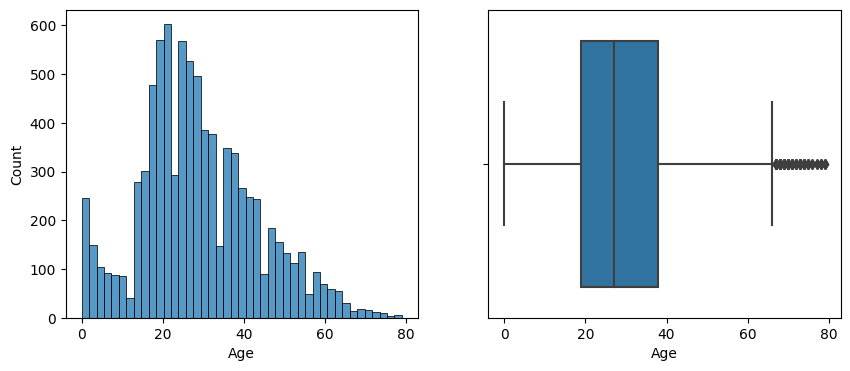

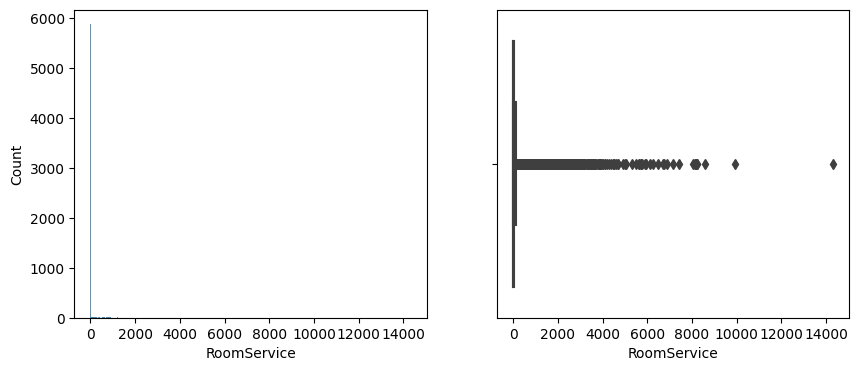

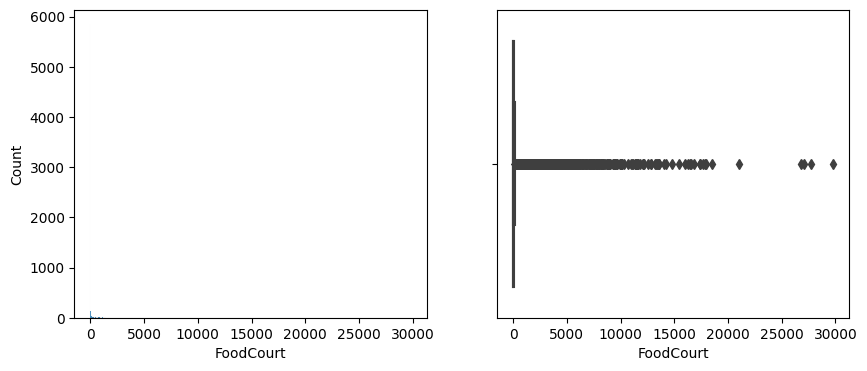

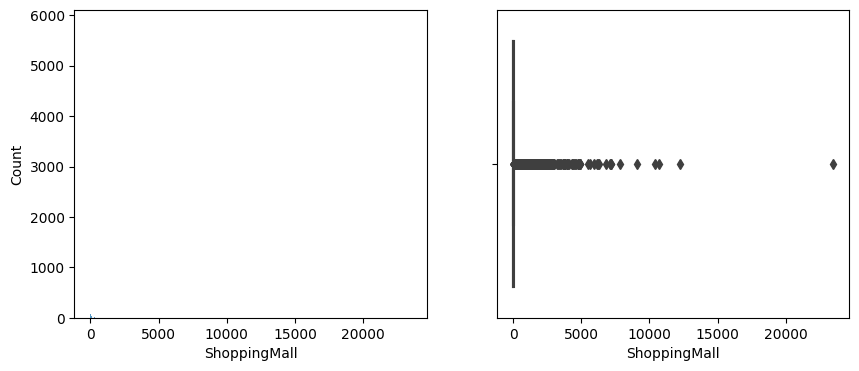

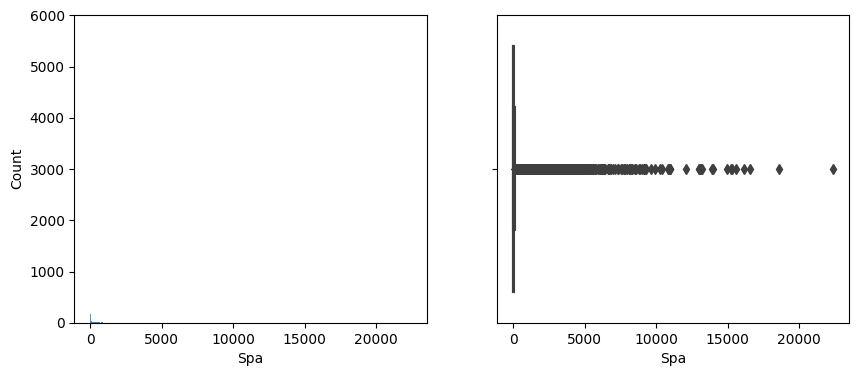

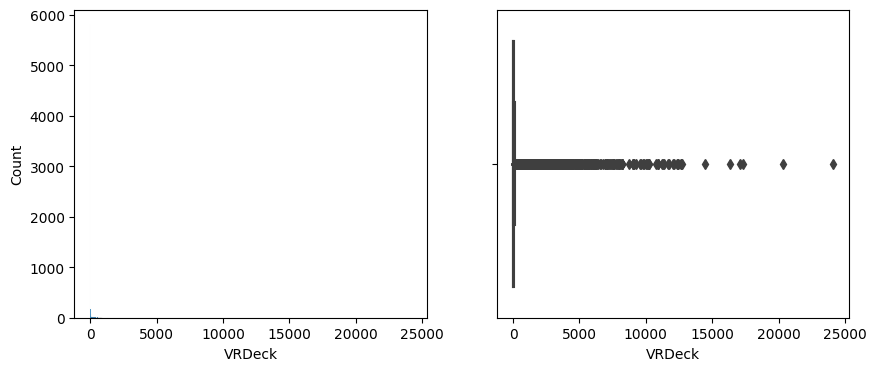

In [12]:
numeric_cols = sample.select_dtypes('number').columns 
plot_hists_box(sample, numeric_cols)

# First look

- General
    * NaN values
    * Outliers
    * Hidden features
    * Wrong dtypes

# Outliers & NaN values

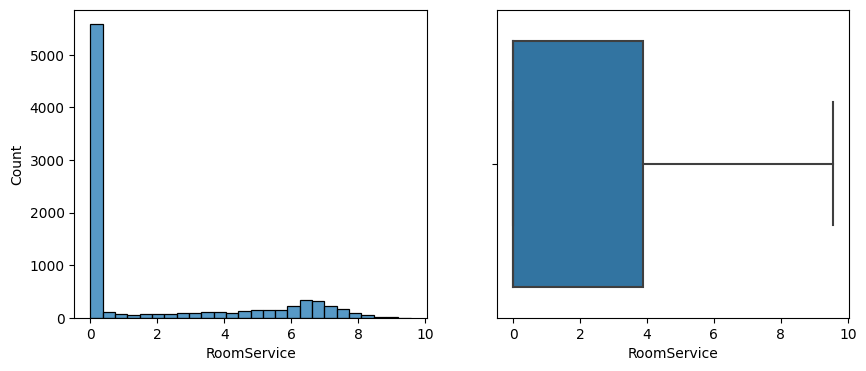

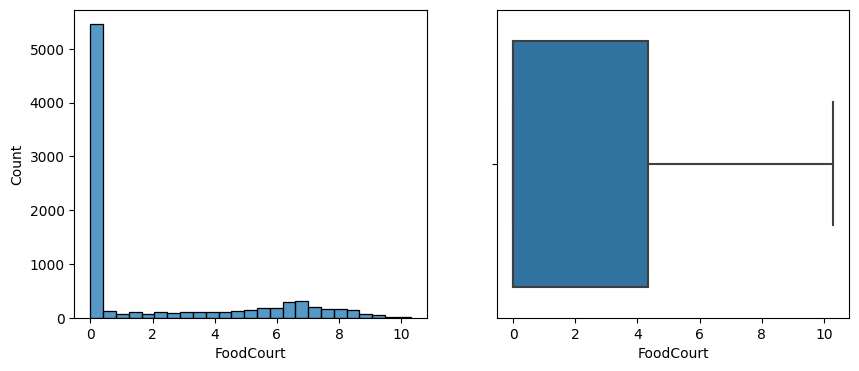

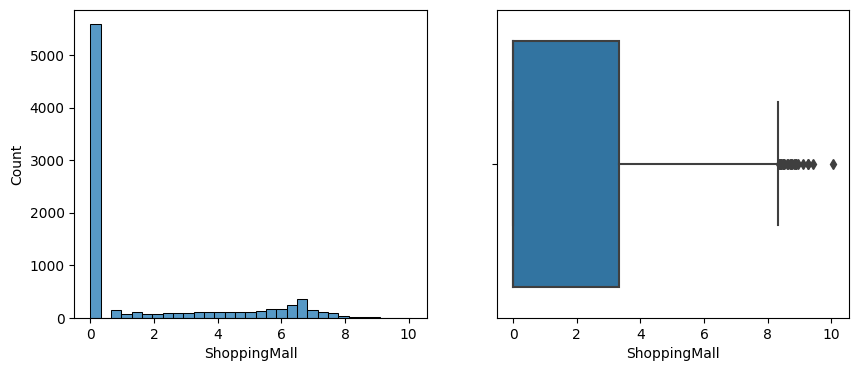

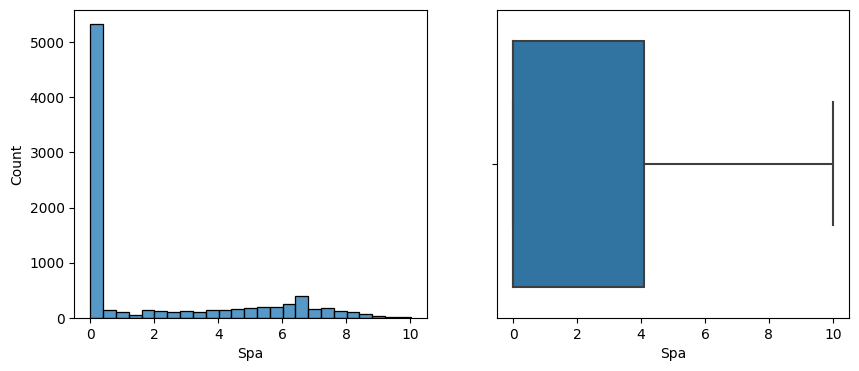

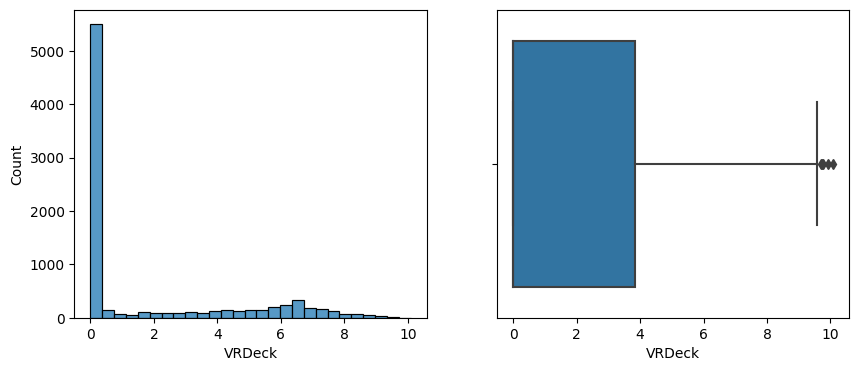

In [13]:
out_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
sample.loc[:, out_cols] = np.log(sample.loc[:, out_cols] + 1) 
plot_hists_box(sample, out_cols)

There are a lot of outliers.
<br> 
So the simplest solution according to distributions (Looks like there is two different classes) is to replace values of all these features with:
   - 0 - didn't spent money
   - 1 - spent money

In this case, i don't see the way to process NaN values. So, KISS, drop NA (If you have a better solution, please, tell me).

In [14]:
sample = sample.dropna()

In [15]:
sample.shape

(6606, 14)

In [16]:
for col in out_cols:
    sample[col] = sample.loc[:, col].apply(lambda x: 0 if x == 0.0 else 1)

# Wrong dtypes

Age: I'm going to use catboost encoder for categorical (bin counts), so I think that converting age to categorical is not such a bad idea. 
<br>
As I said, there are a couple wrong dtypes, let's fix it!  

In [17]:
sample[TARGET] = sample[TARGET].astype(int)
sample["Age"] = sample["Age"].astype(str)
sample["CryoSleep"] = sample["CryoSleep"].astype(int) 
sample["VIP"] = sample["VIP"].astype(int)

In [18]:
sample.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

# Categorical features

Cabin description: "Takes the form deck/num/side, where side can be either P for Port or S for Starboard."
<br>
So we can split this value by '/' and get 3 new features!

In [19]:
sample[["deck", "num", "side"]] = sample["Cabin"].str.split('/', expand=True)
sample[["deck", "num", "side"]]

,deck,num,side
0,B,0,P
1,F,0,S
2,A,0,S
3,A,0,S
4,F,1,S
...,...,...,...
8688,A,98,P
8689,G,1499,S
8690,G,1500,S
8691,E,608,S


Id description: "Each Id takes the form gggg_pp where gggg indicates a group the passenger..." 
<br>
We don't really need unique number of passenger, but we can extract his group. 

In [20]:
sample["Group"] = sample["PassengerId"].str.split('_', expand=True)[0]
sample["Group"]

0       0001
1       0002
2       0003
3       0003
4       0004
        ... 
8688    9276
8689    9278
8690    9279
8691    9280
8692    9280
Name: Group, Length: 6606, dtype: object

We can use surname as indicator of family.
<br>
Although there could be namesakes, we extracted groups, which could help us indicate families. 

In [21]:
sample["Surname"] = sample["Name"].str.split(' ', expand=True)[1]
sample["Surname"]

0         Ofracculy
1             Vines
2            Susent
3            Susent
4       Santantines
           ...     
8688      Noxnuther
8689      Mondalley
8690         Connon
8691      Hontichre
8692      Hontichre
Name: Surname, Length: 6606, dtype: object

In [22]:
sample = sample.drop(columns = ["Cabin", "Name", "PassengerId"])

# Look at the unique values again

In [23]:
str_cols = sample.select_dtypes('object').columns
unique_report(sample, str_cols)

Feature: HomePlanet
             Unique values count: (3,)
             Unique values: ['Europa' 'Earth' 'Mars']

Feature: Destination
             Unique values count: (3,)
             Unique values: ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e']

Feature: Age
             Unique values count: (80,)
             Unique values: ['39.0' '24.0' '58.0' '33.0' '16.0' '44.0' '26.0' '35.0' '14.0' '45.0'
 '32.0' '48.0' '28.0' '0.0' '1.0' '49.0' '10.0' '7.0' '15.0' '34.0' '43.0'
 '47.0' '2.0' '23.0' '20.0' '17.0' '55.0' '4.0' '21.0' '56.0' '25.0'
 '38.0' '27.0' '36.0' '22.0' '62.0' '18.0' '19.0' '37.0' '42.0' '13.0'
 '40.0' '3.0' '54.0' '9.0' '6.0' '29.0' '64.0' '67.0' '61.0' '50.0' '31.0'
 '8.0' '51.0' '11.0' '41.0' '30.0' '46.0' '60.0' '63.0' '57.0' '5.0'
 '79.0' '68.0' '59.0' '74.0' '12.0' '65.0' '53.0' '71.0' '52.0' '75.0'
 '76.0' '78.0' '70.0' '73.0' '66.0' '69.0' '72.0' '77.0']

Feature: deck
             Unique values count: (8,)
             Unique values: ['B' 'F' 'A' 'G' 'E' 'C' 'D' 

# Run catboost encoder to process categorical

In [24]:
encoder = ce.cat_boost.CatBoostEncoder()
encoder.fit(sample[str_cols], sample[TARGET])
sample[str_cols] = encoder.transform(sample.loc[:, str_cols])

# Look at the data

In [25]:
sample.head(20)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,deck,num,side,Group,Surname
0,0.659799,0,0.466791,0.421330,0,0,0,0,0,0,0,0.728941,0.423356,0.449878,0.503633,0.503633
1,0.425709,0,0.466791,0.443374,0,1,1,1,1,1,1,0.435441,0.423356,0.556038,0.503633,0.875908
2,0.659799,0,0.466791,0.430656,1,1,1,0,1,1,0,0.487998,0.423356,0.556038,0.167878,0.583939
3,0.659799,0,0.466791,0.445679,0,0,1,1,1,1,0,0.487998,0.423356,0.556038,0.167878,0.583939
4,0.425709,0,0.466791,0.566701,0,1,1,1,1,1,1,0.435441,0.731049,0.556038,0.503633,0.583939
5,0.425709,0,0.505615,0.511277,0,0,1,0,1,0,1,0.435441,0.423356,0.449878,0.503633,0.500727
6,0.425709,0,0.466791,0.507160,0,1,1,1,0,0,1,0.435441,0.437954,0.556038,0.503633,0.250606
8,0.425709,0,0.466791,0.496350,0,0,1,1,1,0,1,0.435441,0.700242,0.556038,0.503633,0.417272
9,0.659799,1,0.622517,0.534814,0,0,0,0,0,0,1,0.728941,0.731049,0.449878,0.834544,0.834544
11,0.659799,0,0.622517,0.458954,0,1,1,1,1,1,1,0.728941,0.731049,0.449878,0.834544,0.834544


# Look at the target balance (Because I removed a lot of data)
It's ok

<AxesSubplot:>

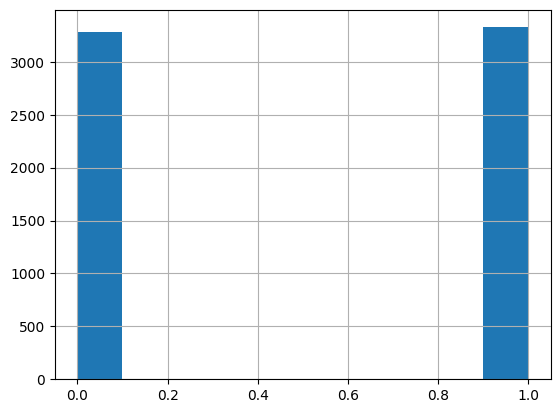

In [26]:
sample["Transported"].hist()

In [27]:
sample.to_pickle(PREPROCESSED / "preprocessed_train.pickle")

# Prepare data to train

In [28]:
predictors = sample.loc[:, sample.columns != "Transported"]
target = sample["Transported"]

# Train LGBM

In [29]:
score, model = train(LGBMClassifier, predictors, target)
print(f"\nTEST SCORE IS {score}")

[I 2023-02-07 13:18:52,770] A new study created in memory with name: test
C:\Users\20318156\AppData\Roaming\Python\Python310\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()
Best trial: 0. Best value: 0.849809:   1%|          | 1/100 [00:06<11:05,  6.72s/it]

[I 2023-02-07 13:18:59,488] Trial 0 finished with value: 0.8498088361551478 and parameters: {'n_estimators': 335, 'learning_rate': 0.05521794261471533, 'max_depth': 7, 'subsample': 0.7570718389822694, 'min_child_weight': 6}. Best is trial 0 with value: 0.8498088361551478.


Best trial: 0. Best value: 0.849809:   2%|▏         | 2/100 [00:13<11:10,  6.84s/it]

[I 2023-02-07 13:19:06,416] Trial 1 finished with value: 0.8415286488288196 and parameters: {'n_estimators': 371, 'learning_rate': 0.09811242814700431, 'max_depth': 7, 'subsample': 0.95986304557371, 'min_child_weight': 3}. Best is trial 0 with value: 0.8498088361551478.


Best trial: 0. Best value: 0.849809:   3%|▎         | 3/100 [00:18<09:31,  5.89s/it]

[I 2023-02-07 13:19:11,168] Trial 2 finished with value: 0.8447452505260268 and parameters: {'n_estimators': 234, 'learning_rate': 0.1025000844270316, 'max_depth': 6, 'subsample': 0.7935768203879033, 'min_child_weight': 2}. Best is trial 0 with value: 0.8498088361551478.


Best trial: 3. Best value: 0.851032:   4%|▍         | 4/100 [00:20<07:11,  4.49s/it]

[I 2023-02-07 13:19:13,524] Trial 3 finished with value: 0.851032462321309 and parameters: {'n_estimators': 136, 'learning_rate': 0.10992023998206382, 'max_depth': 6, 'subsample': 0.9328400713729286, 'min_child_weight': 8}. Best is trial 3 with value: 0.851032462321309.


Best trial: 4. Best value: 0.852669:   5%|▌         | 5/100 [00:23<06:02,  3.82s/it]

[I 2023-02-07 13:19:16,149] Trial 4 finished with value: 0.8526693630941938 and parameters: {'n_estimators': 232, 'learning_rate': 0.10785039319797665, 'max_depth': 4, 'subsample': 0.9919068619825437, 'min_child_weight': 8}. Best is trial 4 with value: 0.8526693630941938.


Best trial: 4. Best value: 0.852669:   6%|▌         | 6/100 [00:30<07:58,  5.09s/it]

[I 2023-02-07 13:19:23,707] Trial 5 finished with value: 0.8431955424205781 and parameters: {'n_estimators': 500, 'learning_rate': 0.07789611369845416, 'max_depth': 5, 'subsample': 0.5056583587969745, 'min_child_weight': 7}. Best is trial 4 with value: 0.8526693630941938.


Best trial: 4. Best value: 0.852669:   7%|▋         | 7/100 [00:32<06:15,  4.04s/it]

[I 2023-02-07 13:19:25,591] Trial 6 finished with value: 0.8505843922764005 and parameters: {'n_estimators': 104, 'learning_rate': 0.05980495799536395, 'max_depth': 8, 'subsample': 0.9791641454760631, 'min_child_weight': 10}. Best is trial 4 with value: 0.8526693630941938.


Best trial: 4. Best value: 0.852669:   8%|▊         | 8/100 [00:35<05:28,  3.57s/it]

[I 2023-02-07 13:19:28,152] Trial 7 finished with value: 0.8371567039995215 and parameters: {'n_estimators': 286, 'learning_rate': 0.018932187824771254, 'max_depth': 2, 'subsample': 0.7801045938731563, 'min_child_weight': 5}. Best is trial 4 with value: 0.8526693630941938.


Best trial: 4. Best value: 0.852669:   9%|▉         | 9/100 [00:40<06:10,  4.07s/it]

[I 2023-02-07 13:19:33,321] Trial 8 finished with value: 0.8440938058782235 and parameters: {'n_estimators': 288, 'learning_rate': 0.11408266211943725, 'max_depth': 5, 'subsample': 0.6672134742815041, 'min_child_weight': 6}. Best is trial 4 with value: 0.8526693630941938.


Best trial: 4. Best value: 0.852669:  10%|█         | 10/100 [00:42<05:21,  3.57s/it]

[I 2023-02-07 13:19:35,766] Trial 9 finished with value: 0.8369762477373248 and parameters: {'n_estimators': 284, 'learning_rate': 0.017958968206054634, 'max_depth': 2, 'subsample': 0.6323657595763696, 'min_child_weight': 8}. Best is trial 4 with value: 0.8526693630941938.


Best trial: 4. Best value: 0.852669:  11%|█         | 11/100 [00:45<04:50,  3.27s/it]

[I 2023-02-07 13:19:38,351] Trial 10 finished with value: 0.8490984896080509 and parameters: {'n_estimators': 187, 'learning_rate': 0.12185904945108952, 'max_depth': 4, 'subsample': 0.9071804996516133, 'min_child_weight': 10}. Best is trial 4 with value: 0.8526693630941938.


Best trial: 11. Best value: 0.854164:  12%|█▏        | 12/100 [00:47<04:04,  2.78s/it]

[I 2023-02-07 13:19:39,999] Trial 11 finished with value: 0.854164175949325 and parameters: {'n_estimators': 113, 'learning_rate': 0.09290898974716477, 'max_depth': 4, 'subsample': 0.8909643365847183, 'min_child_weight': 8}. Best is trial 11 with value: 0.854164175949325.


Best trial: 11. Best value: 0.854164:  13%|█▎        | 13/100 [00:49<03:43,  2.57s/it]

[I 2023-02-07 13:19:42,098] Trial 12 finished with value: 0.8526973006852284 and parameters: {'n_estimators': 188, 'learning_rate': 0.087388502992362, 'max_depth': 3, 'subsample': 0.8691688713877049, 'min_child_weight': 9}. Best is trial 11 with value: 0.854164175949325.


Best trial: 11. Best value: 0.854164:  14%|█▍        | 14/100 [00:51<03:28,  2.43s/it]

[I 2023-02-07 13:19:44,199] Trial 13 finished with value: 0.8533612936896515 and parameters: {'n_estimators': 158, 'learning_rate': 0.083306092009425, 'max_depth': 3, 'subsample': 0.8523942812854133, 'min_child_weight': 9}. Best is trial 11 with value: 0.854164175949325.


Best trial: 11. Best value: 0.854164:  15%|█▌        | 15/100 [00:52<02:59,  2.12s/it]

[I 2023-02-07 13:19:45,590] Trial 14 finished with value: 0.8488335355448514 and parameters: {'n_estimators': 137, 'learning_rate': 0.07389512535847247, 'max_depth': 3, 'subsample': 0.8516492350584073, 'min_child_weight': 4}. Best is trial 11 with value: 0.854164175949325.


Best trial: 11. Best value: 0.854164:  16%|█▌        | 16/100 [00:54<02:50,  2.03s/it]

[I 2023-02-07 13:19:47,403] Trial 15 finished with value: 0.8531617667841477 and parameters: {'n_estimators': 110, 'learning_rate': 0.08800641853577779, 'max_depth': 4, 'subsample': 0.8540498195217248, 'min_child_weight': 9}. Best is trial 11 with value: 0.854164175949325.


Best trial: 11. Best value: 0.854164:  17%|█▋        | 17/100 [00:56<02:49,  2.04s/it]

[I 2023-02-07 13:19:49,471] Trial 16 finished with value: 0.8517514484198381 and parameters: {'n_estimators': 173, 'learning_rate': 0.12353610282308233, 'max_depth': 3, 'subsample': 0.8887918598470322, 'min_child_weight': 7}. Best is trial 11 with value: 0.854164175949325.


Best trial: 11. Best value: 0.854164:  18%|█▊        | 18/100 [01:06<05:56,  4.35s/it]

[I 2023-02-07 13:19:59,193] Trial 17 finished with value: 0.84654403597372 and parameters: {'n_estimators': 417, 'learning_rate': 0.0509662334221964, 'max_depth': 9, 'subsample': 0.8186838220594803, 'min_child_weight': 9}. Best is trial 11 with value: 0.854164175949325.


Best trial: 11. Best value: 0.854164:  19%|█▉        | 19/100 [01:09<05:09,  3.82s/it]

[I 2023-02-07 13:20:01,783] Trial 18 finished with value: 0.8507720750093799 and parameters: {'n_estimators': 235, 'learning_rate': 0.09352617404668218, 'max_depth': 2, 'subsample': 0.926280460899537, 'min_child_weight': 7}. Best is trial 11 with value: 0.854164175949325.


Best trial: 11. Best value: 0.854164:  20%|██        | 20/100 [01:11<04:40,  3.51s/it]

[I 2023-02-07 13:20:04,550] Trial 19 finished with value: 0.8515526079020109 and parameters: {'n_estimators': 159, 'learning_rate': 0.07331904875376634, 'max_depth': 4, 'subsample': 0.8215077919045606, 'min_child_weight': 1}. Best is trial 11 with value: 0.854164175949325.


Best trial: 20. Best value: 0.854403:  21%|██        | 21/100 [01:15<04:40,  3.56s/it]

[I 2023-02-07 13:20:08,232] Trial 20 finished with value: 0.8544025526357375 and parameters: {'n_estimators': 223, 'learning_rate': 0.043986178975824, 'max_depth': 5, 'subsample': 0.8956534854976819, 'min_child_weight': 5}. Best is trial 20 with value: 0.8544025526357375.


Best trial: 20. Best value: 0.854403:  22%|██▏       | 22/100 [01:19<04:51,  3.73s/it]

[I 2023-02-07 13:20:12,383] Trial 21 finished with value: 0.8530975760156982 and parameters: {'n_estimators': 215, 'learning_rate': 0.04357291453910622, 'max_depth': 5, 'subsample': 0.9010011992970204, 'min_child_weight': 5}. Best is trial 20 with value: 0.8544025526357375.


Best trial: 20. Best value: 0.854403:  22%|██▏       | 22/100 [01:21<04:48,  3.70s/it]


[I 2023-02-07 13:20:14,120] Trial 22 finished with value: 0.8435242964660936 and parameters: {'n_estimators': 146, 'learning_rate': 0.03452102593371856, 'max_depth': 3, 'subsample': 0.8637927066848754, 'min_child_weight': 4}. Best is trial 20 with value: 0.8544025526357375.
EarlyStopping Exceeded: No new best scores on iters 20

TEST SCORE IS 0.8418640183346066


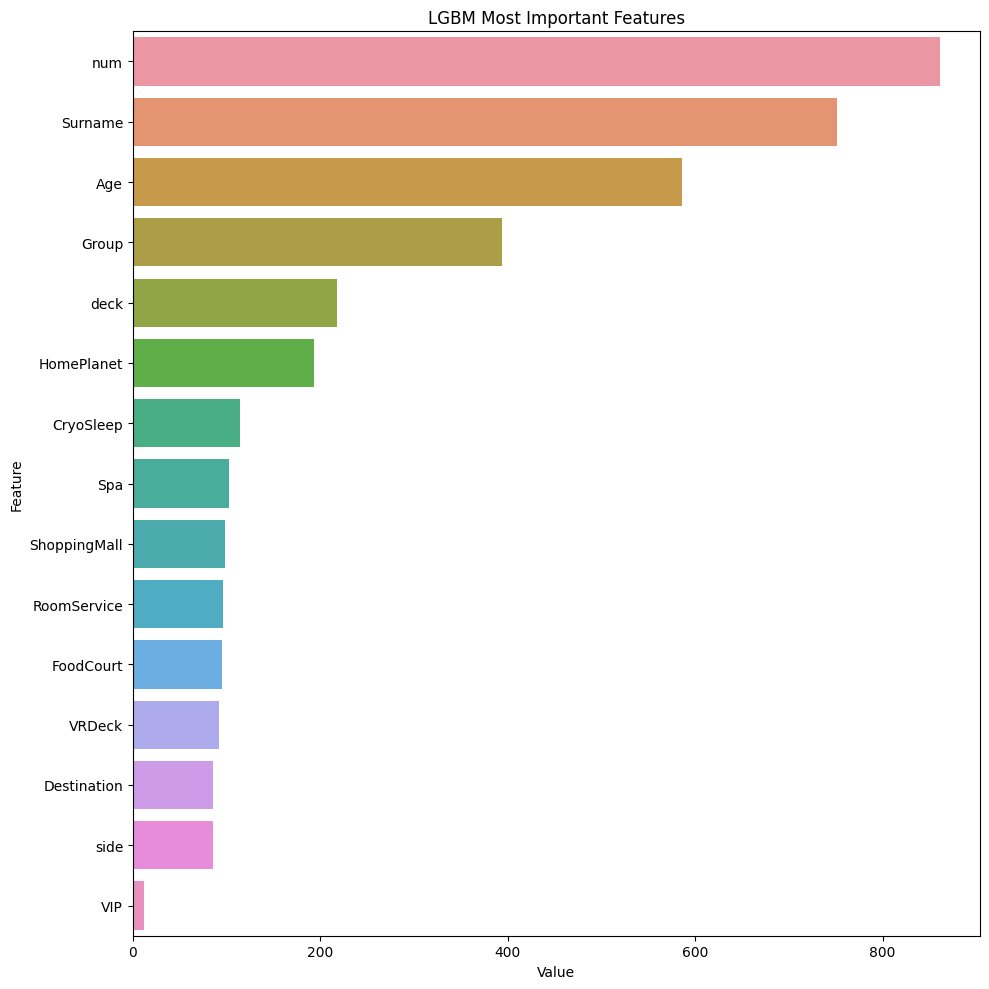

In [30]:
plot_feature_importance(model, predictors, "LGBM")

# Train XGBoost

In [31]:
score, model = train(XGBClassifier, predictors, target)
print(f"\nTEST SCORE IS {score}")

[I 2023-02-07 13:20:15,280] A new study created in memory with name: test
C:\Users\20318156\AppData\Roaming\Python\Python310\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()
Best trial: 0. Best value: 0.841839:   1%|          | 1/100 [00:04<07:42,  4.67s/it]

[I 2023-02-07 13:20:19,926] Trial 0 finished with value: 0.8418392179274148 and parameters: {'n_estimators': 358, 'learning_rate': 0.01314145817609196, 'max_depth': 3, 'subsample': 0.7414959670838428, 'min_child_weight': 7}. Best is trial 0 with value: 0.8418392179274148.


Best trial: 1. Best value: 0.848412:   2%|▏         | 2/100 [00:14<12:07,  7.42s/it]

[I 2023-02-07 13:20:29,301] Trial 1 finished with value: 0.8484123296683835 and parameters: {'n_estimators': 354, 'learning_rate': 0.025018044773153926, 'max_depth': 6, 'subsample': 0.7307396175118027, 'min_child_weight': 3}. Best is trial 1 with value: 0.8484123296683835.


Best trial: 2. Best value: 0.849361:   3%|▎         | 3/100 [00:17<09:26,  5.84s/it]

[I 2023-02-07 13:20:33,263] Trial 2 finished with value: 0.8493612370568956 and parameters: {'n_estimators': 225, 'learning_rate': 0.08494241249558877, 'max_depth': 5, 'subsample': 0.5367804942336916, 'min_child_weight': 9}. Best is trial 2 with value: 0.8493612370568956.


Best trial: 2. Best value: 0.849361:   4%|▍         | 4/100 [00:20<06:58,  4.35s/it]

[I 2023-02-07 13:20:35,336] Trial 3 finished with value: 0.8483506221257254 and parameters: {'n_estimators': 114, 'learning_rate': 0.08373371750795464, 'max_depth': 5, 'subsample': 0.664407775310083, 'min_child_weight': 9}. Best is trial 2 with value: 0.8493612370568956.


Best trial: 2. Best value: 0.849361:   5%|▌         | 5/100 [00:30<10:36,  6.70s/it]

[I 2023-02-07 13:20:46,181] Trial 4 finished with value: 0.8408664649470268 and parameters: {'n_estimators': 372, 'learning_rate': 0.09185762599836313, 'max_depth': 9, 'subsample': 0.8962768909181413, 'min_child_weight': 10}. Best is trial 2 with value: 0.8493612370568956.


Best trial: 5. Best value: 0.852402:   6%|▌         | 6/100 [00:32<07:52,  5.03s/it]

[I 2023-02-07 13:20:47,968] Trial 5 finished with value: 0.8524022368846997 and parameters: {'n_estimators': 109, 'learning_rate': 0.08010440074146398, 'max_depth': 3, 'subsample': 0.5240430269132765, 'min_child_weight': 8}. Best is trial 5 with value: 0.8524022368846997.


Best trial: 5. Best value: 0.852402:   7%|▋         | 7/100 [00:37<07:50,  5.06s/it]

[I 2023-02-07 13:20:53,110] Trial 6 finished with value: 0.8486328273042579 and parameters: {'n_estimators': 321, 'learning_rate': 0.07233164008953914, 'max_depth': 2, 'subsample': 0.956854795917405, 'min_child_weight': 3}. Best is trial 5 with value: 0.8524022368846997.


Best trial: 5. Best value: 0.852402:   8%|▊         | 8/100 [00:48<10:38,  6.94s/it]

[I 2023-02-07 13:21:04,059] Trial 7 finished with value: 0.8356680330753002 and parameters: {'n_estimators': 474, 'learning_rate': 0.08281987691136113, 'max_depth': 7, 'subsample': 0.5344782431849687, 'min_child_weight': 2}. Best is trial 5 with value: 0.8524022368846997.


Best trial: 5. Best value: 0.852402:   9%|▉         | 9/100 [00:56<10:56,  7.21s/it]

[I 2023-02-07 13:21:11,851] Trial 8 finished with value: 0.8447295179527572 and parameters: {'n_estimators': 346, 'learning_rate': 0.06694145438624684, 'max_depth': 8, 'subsample': 0.571557111093575, 'min_child_weight': 7}. Best is trial 5 with value: 0.8524022368846997.


Best trial: 5. Best value: 0.852402:  10%|█         | 10/100 [01:06<12:17,  8.20s/it]

[I 2023-02-07 13:21:22,268] Trial 9 finished with value: 0.8499404224588897 and parameters: {'n_estimators': 427, 'learning_rate': 0.023365548809274744, 'max_depth': 6, 'subsample': 0.5392375355529262, 'min_child_weight': 8}. Best is trial 5 with value: 0.8524022368846997.


Best trial: 5. Best value: 0.852402:  11%|█         | 11/100 [01:08<09:08,  6.16s/it]

[I 2023-02-07 13:21:23,822] Trial 10 finished with value: 0.8493270844650717 and parameters: {'n_estimators': 109, 'learning_rate': 0.11715125528729953, 'max_depth': 3, 'subsample': 0.6300672596607162, 'min_child_weight': 5}. Best is trial 5 with value: 0.8524022368846997.


Best trial: 5. Best value: 0.852402:  12%|█▏        | 12/100 [01:14<09:09,  6.24s/it]

[I 2023-02-07 13:21:30,237] Trial 11 finished with value: 0.8508144407958671 and parameters: {'n_estimators': 495, 'learning_rate': 0.03872180801273457, 'max_depth': 4, 'subsample': 0.5008531435180884, 'min_child_weight': 7}. Best is trial 5 with value: 0.8524022368846997.


Best trial: 5. Best value: 0.852402:  13%|█▎        | 13/100 [01:18<07:50,  5.41s/it]

[I 2023-02-07 13:21:33,726] Trial 12 finished with value: 0.8491141482798337 and parameters: {'n_estimators': 231, 'learning_rate': 0.044992098194131684, 'max_depth': 4, 'subsample': 0.5030412683999973, 'min_child_weight': 5}. Best is trial 5 with value: 0.8524022368846997.


Best trial: 5. Best value: 0.852402:  14%|█▍        | 14/100 [01:20<06:28,  4.52s/it]

[I 2023-02-07 13:21:36,180] Trial 13 finished with value: 0.8454078930712795 and parameters: {'n_estimators': 237, 'learning_rate': 0.0467872621768588, 'max_depth': 2, 'subsample': 0.6202728833949458, 'min_child_weight': 6}. Best is trial 5 with value: 0.8524022368846997.


Best trial: 5. Best value: 0.852402:  15%|█▌        | 15/100 [01:28<07:31,  5.31s/it]

[I 2023-02-07 13:21:43,328] Trial 14 finished with value: 0.8201528795214404 and parameters: {'n_estimators': 499, 'learning_rate': 0.0015783509287190592, 'max_depth': 4, 'subsample': 0.610390981989747, 'min_child_weight': 7}. Best is trial 5 with value: 0.8524022368846997.


Best trial: 5. Best value: 0.852402:  16%|█▌        | 16/100 [01:30<06:12,  4.43s/it]

[I 2023-02-07 13:21:45,733] Trial 15 finished with value: 0.8502791662639447 and parameters: {'n_estimators': 173, 'learning_rate': 0.048835258474864154, 'max_depth': 4, 'subsample': 0.5074536256840221, 'min_child_weight': 10}. Best is trial 5 with value: 0.8524022368846997.


Best trial: 5. Best value: 0.852402:  17%|█▋        | 17/100 [01:33<05:42,  4.12s/it]

[I 2023-02-07 13:21:49,130] Trial 16 finished with value: 0.851072543966694 and parameters: {'n_estimators': 274, 'learning_rate': 0.05712095298496169, 'max_depth': 3, 'subsample': 0.6754722337739922, 'min_child_weight': 6}. Best is trial 5 with value: 0.8524022368846997.


Best trial: 5. Best value: 0.852402:  18%|█▊        | 18/100 [01:35<04:47,  3.50s/it]

[I 2023-02-07 13:21:51,183] Trial 17 finished with value: 0.8490683173854757 and parameters: {'n_estimators': 155, 'learning_rate': 0.058990683011634876, 'max_depth': 3, 'subsample': 0.6905048433835747, 'min_child_weight': 5}. Best is trial 5 with value: 0.8524022368846997.


Best trial: 5. Best value: 0.852402:  19%|█▉        | 19/100 [01:38<04:19,  3.20s/it]

[I 2023-02-07 13:21:53,688] Trial 18 finished with value: 0.8514533644373788 and parameters: {'n_estimators': 271, 'learning_rate': 0.1026262320975685, 'max_depth': 2, 'subsample': 0.7740483490281673, 'min_child_weight': 4}. Best is trial 5 with value: 0.8524022368846997.


Best trial: 5. Best value: 0.852402:  20%|██        | 20/100 [01:40<03:40,  2.75s/it]

[I 2023-02-07 13:21:55,402] Trial 19 finished with value: 0.8494405273089736 and parameters: {'n_estimators': 183, 'learning_rate': 0.10440994252351525, 'max_depth': 2, 'subsample': 0.814668732667579, 'min_child_weight': 1}. Best is trial 5 with value: 0.8524022368846997.


Best trial: 5. Best value: 0.852402:  21%|██        | 21/100 [01:42<03:33,  2.70s/it]

[I 2023-02-07 13:21:57,964] Trial 20 finished with value: 0.8502834540289397 and parameters: {'n_estimators': 281, 'learning_rate': 0.10336341303257794, 'max_depth': 2, 'subsample': 0.7921337513694136, 'min_child_weight': 4}. Best is trial 5 with value: 0.8524022368846997.


Best trial: 21. Best value: 0.853533:  22%|██▏       | 22/100 [01:46<03:47,  2.92s/it]

[I 2023-02-07 13:22:01,400] Trial 21 finished with value: 0.8535332836151669 and parameters: {'n_estimators': 269, 'learning_rate': 0.0672798346486008, 'max_depth': 3, 'subsample': 0.689969592318465, 'min_child_weight': 6}. Best is trial 21 with value: 0.8535332836151669.


Best trial: 21. Best value: 0.853533:  22%|██▏       | 22/100 [01:51<06:36,  5.09s/it]


[I 2023-02-07 13:22:07,219] Trial 22 finished with value: 0.8478043090796776 and parameters: {'n_estimators': 421, 'learning_rate': 0.07286031128233525, 'max_depth': 3, 'subsample': 0.797598190382768, 'min_child_weight': 4}. Best is trial 21 with value: 0.8535332836151669.
EarlyStopping Exceeded: No new best scores on iters 20

TEST SCORE IS 0.8479117415287628


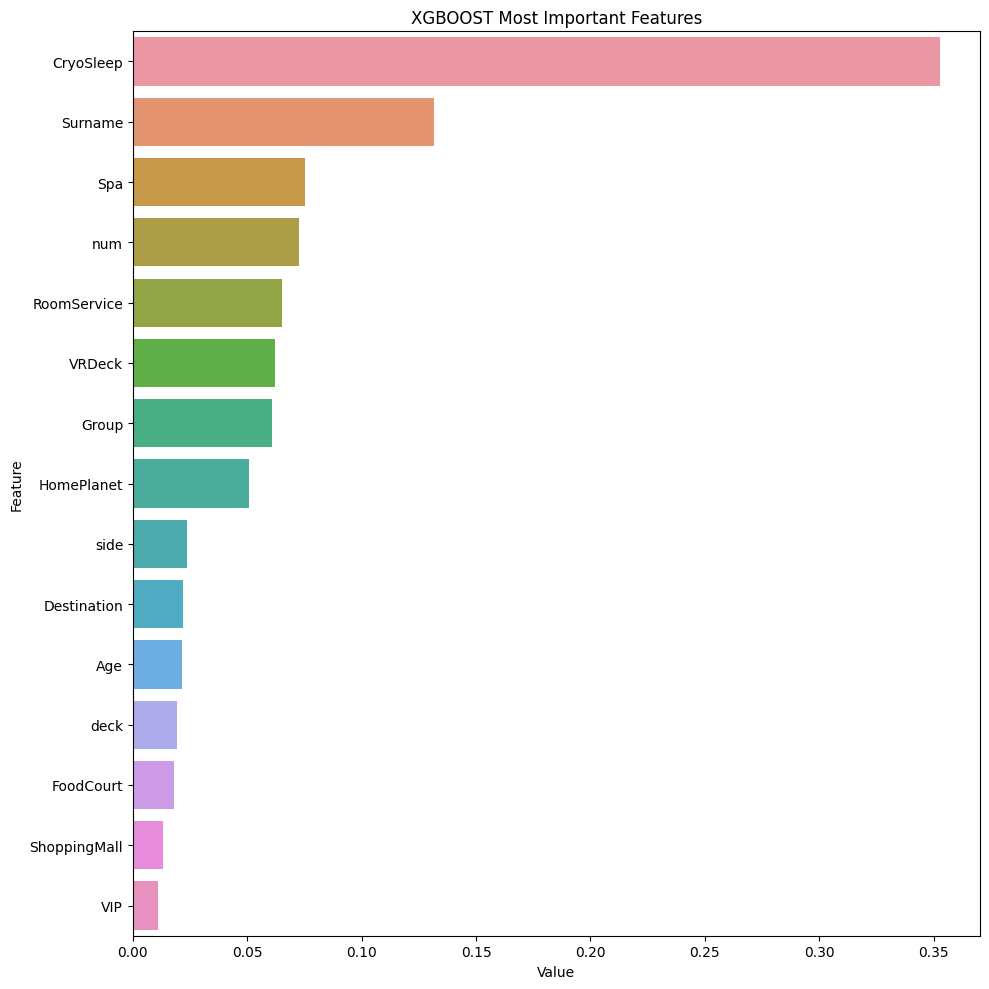

In [32]:
plot_feature_importance(model, predictors, "XGBOOST")

# References
* https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook (EN)
* https://machinelearningmastery.com/configure-gradient-boosting-algorithm/ (EN)
* https://habr.com/ru/post/540656/ (RU)
* https://github.com/optuna/optuna/issues/966 (EN)